# Data Generation

First we pick out the dimensions and scales:

A_scale = ( (GM_sun_length^5 / light_second^2)^(1/3) ) / (kilo_parsec)

f_scale = ( GM_sun^(1/2) / ((r_scale_units)^(3/2)))

In [80]:
A_scale = 1.385328279341387e-20
f_scale = 0.011520088541326409

A_i = lambda Mc, d: A_scale * (Mc**(5/3) / d)  # A_i(Mc, d)
A_i_f = lambda Mc, d, f: A_scale * (Mc**(5/3) / d) * (np.pi * f)**(2/3)  # A_i(Mc, d, f)
f_i = lambda Mc, r: f_scale * np.sqrt(Mc / np.pi) * r**(-3/2)  # f_i(Mc, r)

import numpy as np
import matplotlib.pyplot as plt

# Define sample_rate, duration, ϕ, Mc, r, d
sample_rate = 0.25
duration = 10_000

# Generate time values
ts = np.linspace(0, duration, int(sample_rate * duration))

# Define the S_forward function
S_forward = lambda t, f, phi, A: A * np.sin((2 * np.pi * f * t) + phi)

# Sampling from TruncatedPowerLaw

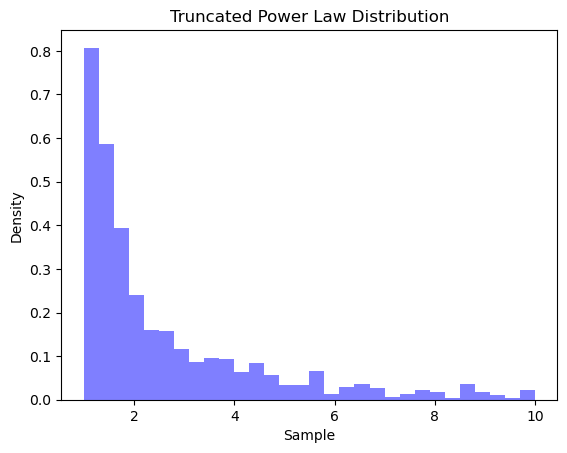

In [99]:
import numpy as np
from scipy.stats import expon

class TruncatedPowerLaw:
    def __init__(self, alpha, a, b):
        self.alpha = alpha
        self.a = a
        self.b = b
        self.cdf_a = expon.cdf(a)
        self.cdf_b = expon.cdf(b)
        self.norm_const = 1 / (self.cdf_b - self.cdf_a)

    def logpdf(self, x):
        if x < self.a or x > self.b:
            return -np.inf  # Outside of the defined range
        else:
            return np.log(self.norm_const) - (self.alpha + 1) * np.log(x)

    def sample(self, size=1):
        u = np.random.uniform(0, 1, size)
        z = u * (self.b**(self.alpha + 1) - self.a**(self.alpha + 1)) + self.a**(self.alpha + 1)
        return z**(1/(self.alpha + 1))  # Inverse CDF sampling

# Example usage:
alpha = -2.0
a = 1.0
b = 10.0

# Create a truncated power-law distribution
tpl_dist = TruncatedPowerLaw(alpha, a, b)

# Generate random samples from the distribution
samples = tpl_dist.sample(1000)

# Plot a histogram of the samples
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.5, color='b')
plt.xlabel('Sample')
plt.ylabel('Density')
plt.title('Truncated Power Law Distribution')
plt.show()


In [100]:
import pandas as pd

Lambda = {'alpha' : -1.2, 'beta' : -2.0}
limits = {'Mc' : [0.5, 1.4], 'r': [0.5, 20], 'd':[1, 50], 'phi':[0,2*np.pi]}


shape = (1000,)

PopulationInjection = dict(
                            Mc = TruncatedPowerLaw(Lambda['alpha'], *limits["Mc"]).sample(shape),
                            r = TruncatedPowerLaw(Lambda['beta'], *limits["r"]).sample(shape),
                            d = TruncatedPowerLaw(1.0, *limits["d"]).sample(shape),
                            phi = np.random.rand(*shape)*(limits["phi"][1] - limits["phi"][0]) + limits["phi"][0]
                          )




pd.DataFrame(PopulationInjection)

,Mc,r,d,phi
0,1.275443,0.511508,1.031408,1.318470
1,0.992927,6.793624,7.412416,6.075134
2,0.846780,1.570355,40.304066,6.104109
3,1.020380,3.605711,36.435737,4.120128
4,0.929881,0.723076,44.978026,6.243553
...,...,...,...,...
995,0.730913,1.946789,39.786647,4.665386
996,1.073201,0.715716,47.211086,4.487505
997,0.500840,1.394087,45.273732,5.292073
998,0.846785,0.568837,49.076468,0.103034


# Generate their Time Series and sum them all together

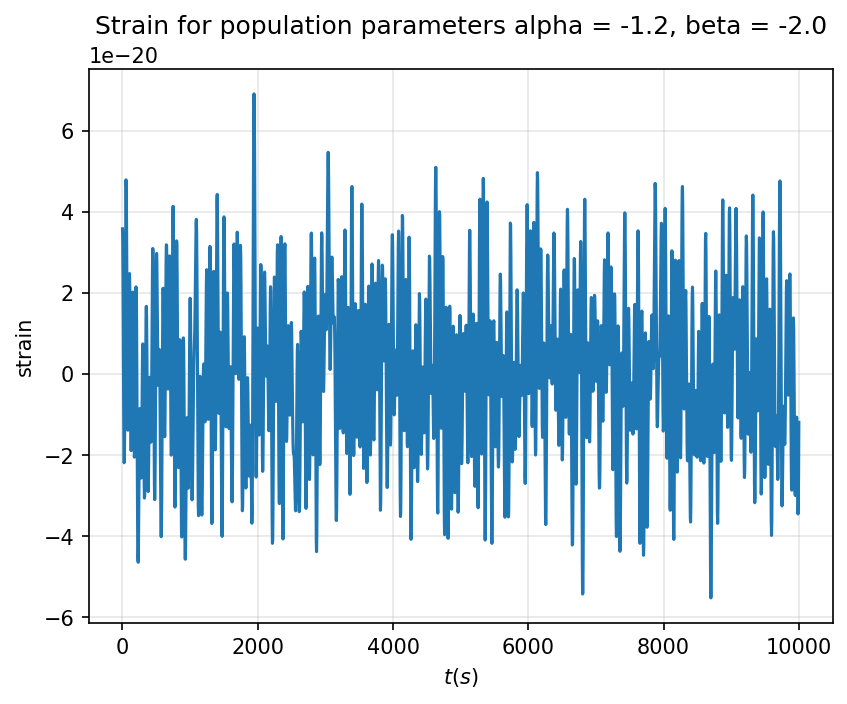

In [108]:
import matplotlib.pyplot as plt

Mc, r, d, phi = PopulationInjection['Mc'], PopulationInjection['r'], PopulationInjection['d'], PopulationInjection['phi']


fig, ax = plt.subplots(dpi=150)
plt.plot(ts, S_forward(ts[:, None], f_i(Mc, r), phi, A_i(Mc, d)).sum(axis=-1))
plt.xlabel(r"$t (s)$")
plt.ylabel(r"strain")
plt.title(f"Strain for population parameters alpha = {np.round(Lambda['alpha'],1)}, beta = {np.round(Lambda['beta'],1)}")
plt.grid(alpha=0.3)
plt.show()